# Measures of model accuracy

In this lesson, we focus on the mathematics we need to better understand model comparison on the metrics commonly used for comparing models.

This lesson is somewhat more mathematical than the rest of the course which may or may not be to your liking. In either case, this material is essential knowledge to truly understand the fields of _Bayesian Statistics_ and _Information Theory_.

Quoting from McElreath:

> At this point in the chapter, dear reader, you may be wondering where the chapter is headed. At the start, the goal was to deal with overfitting and underfitting. But now we’ve spent pages and pages on entropy and other fantasies. It’s as if I promised you a day at the beach, but now you find yourself at a dark cabin in the woods, wondering if this is a necessary detour or rather a sinister plot.

Hold fast! This chapter is essential for understand model comparison and we will get back to applications very soon.

## Prep plan

* The McElreath reading should take ~1 hour. Spend the rest of your time on this workbook — especially the exercises at the end.
* You will find the Python-translated code from the textbook here, as usual.
* There is one code cell below that takes a long time to run. Click “Run All” now so it can complete while you are reading.
* See the _Exercises_ section at the end of the workbook — there are 5 required exercises and 1 optional exercise.



## Required reading: Statistical rethinking

Read Section 7.2 of McElreath, R. (2020). _Statistical Rethinking, Second Edition_. Chapman and Hall/CRC Press.

* [Publisher’s page](https://www.routledge.com/Statistical-Rethinking-A-Bayesian-Course-with-Examples-in-R-and-STAN/McElreath/p/book/9780367139919) for buying the book if you want to
* [The whole book is available online on O’Reilly via the San Francisco Public Library](https://learning-oreilly-com.ezproxy.sfpl.org/library/view/statistical-rethinking-2nd/9780429639142/xhtml/15_Chapter07.xhtml). Log in with your library card number.

**The whole of Section 7.2 (_Entropy and accuracy_) is required** (6100 words). This section connects with our exploration of model evidence in the previous lesson. It formalizes _information entropy_ and _divergence_ as the best measures of uncertainty and of how far away one model (or prediction) is from another. We will apply information and divergence in class. For the applications, you don’t need to understand the mathematical foundations (but it is much better if you do), however, you do need to understand what a divergence value (like 1 or 2.5 or 3.14159) means.

The next part of this workbook contains the R code provided in the McElreath book, translated to Python and PyMC. The code was modified and cleaned up slightly from [the source](https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_07.ipynb) (the `pymc-resources` repository). While reading Section 7.2, you need to follow along in this workbook and run the code as you go.

## Code from Section 7.1

The code below is from Section 7.1 and is necessary to set up the data and models we saw in the previous lesson. Section 7.2 builds on this code.

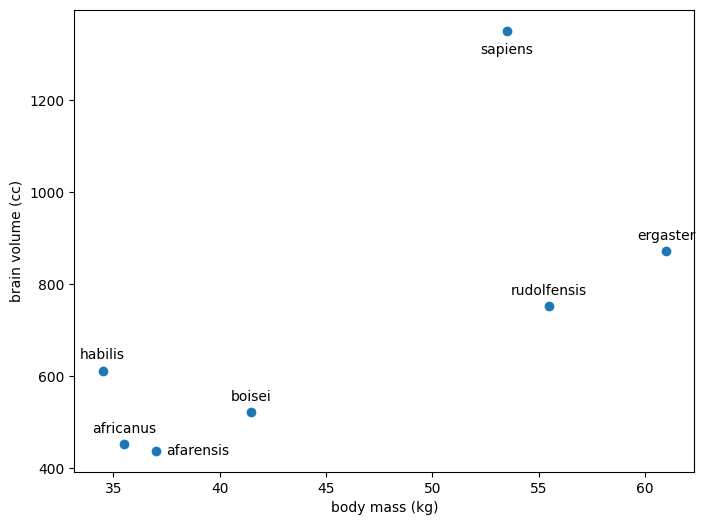

Fitting degree 1 model
Fitting degree 2 model
Fitting degree 3 model
Fitting degree 4 model
Fitting degree 5 model
Fitting degree 6 model


In [1]:
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from patsy import dmatrix


np.random.seed(0)

# Set the default credible interval to match the textbook
az.rcParams["stats.ci_prob"] = 0.89

# Code 7.1: Create data

brains = pd.DataFrame.from_dict({
    "species": [
        "afarensis",
        "africanus",
        "habilis",
        "boisei",
        "rudolfensis",
        "ergaster",
        "sapiens"],
    "brain": [438, 452, 612, 521, 752, 871, 1350],  # volume in cc
    "mass": [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]})  # mass in kg

# Figure 7.2

plt.figure(figsize=(8, 6))
plt.scatter(brains.mass, brains.brain)
for i, r in brains.iterrows():
    if r.species == "afarensis":
        plt.text(r.mass + 0.5, r.brain, r.species, ha="left", va="center")
    elif r.species == "sapiens":
        plt.text(r.mass, r.brain - 25, r.species, ha="center", va="top")
    else:
        plt.text(r.mass, r.brain + 25, r.species, ha="center")
plt.xlabel("body mass (kg)")
plt.ylabel("brain volume (cc)");
plt.show()

# Code 7.2: Standardize data

brains.loc[:, "mass_std"] = (
    (brains.loc[:, "mass"] - brains.loc[:, "mass"].mean()) /
    brains.loc[:, "mass"].std())
brains.loc[:, "brain_std"] = (
    brains.loc[:, "brain"] / brains.loc[:, "brain"].max())

# Fit the polynomial models with degrees 1–6
model_spec = "brain_std ~ mass_std"  # Linear model
print('Fitting degree 1 model')
models = [smf.ols(model_spec, data=brains).fit()]
for degree in range(2, 7):
    print(f'Fitting degree {degree} model')
    # Add another term to the polynomial regression
    model_spec += f" + I(mass_std**{degree})"
    # Fit the model
    models.append(smf.ols(model_spec, data=brains).fit())

## Code from Section 7.2

#### Code 7.12

In [2]:
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

np.float64(0.6108643020548935)

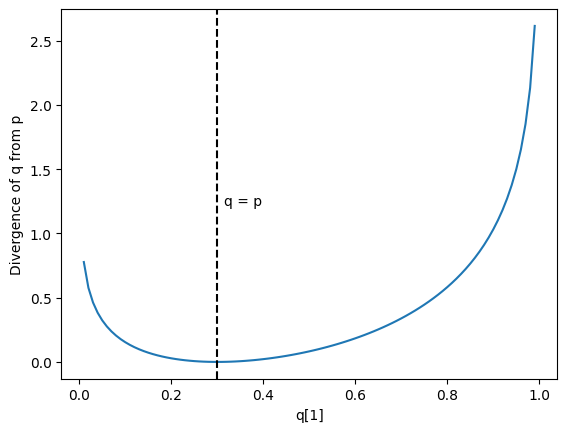

In [3]:
# Figure 7.5
p = np.array([0.3, 0.7])
q = np.arange(0.01, 1, 0.01)
DKL = np.sum(p * np.log(p / np.array([q, 1 - q]).T), 1)

plt.plot(q, DKL)
plt.xlabel("q[1]")
plt.ylabel("Divergence of q from p")
plt.axvline(0.3, ls="dashed", color="k")
plt.text(0.315, 1.22, "q = p");

#### Code 7.13 & 7.14

In [4]:
n_samples = 3000

intercept, slope = stats.multivariate_normal(models[0].params, models[0].cov_params()).rvs(n_samples).T

pred = intercept + slope * brains.mass_std.values.reshape(-1, 1)

n, ns = pred.shape

In [5]:
# PyMC does not have a way to calculate LPPD directly, so we use the approach from 7.14

from scipy.special import logsumexp

sigmas = (np.sum((pred - brains.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5
ll = np.zeros((n, ns))
for s in range(ns):
    logprob = stats.norm.logpdf(brains.brain_std, pred[:, s], sigmas[s])
    ll[:, s] = logprob

lppd = np.zeros(n)
for i in range(n):
    lppd[i] = logsumexp(ll[i]) - np.log(ns)

lppd

array([ 0.61966342,  0.65975191,  0.56628407,  0.62808092,  0.48087061,
        0.45181242, -0.8674653 ])

#### Code 7.15

In [6]:
# make an lppd function that can be applied to all models (from code above)
def lppd(model, n_samples=1e4):
    n_samples = int(n_samples)

    pars = stats.multivariate_normal(model.params, model.cov_params()).rvs(n_samples).T
    dmat = dmatrix(
        model.model.data.design_info, brains, return_type="dataframe"
    ).values  # get model design matrix
    pred = dmat.dot(pars)

    n, ns = pred.shape

    # this approach for calculating lppd isfrom 7.14
    sigmas = (np.sum((pred - brains.brain_std.values.reshape(-1, 1)) ** 2, 0) / 7) ** 0.5
    ll = np.zeros((n, ns))
    for s in range(ns):
        logprob = stats.norm.logpdf(brains.brain_std, pred[:, s], sigmas[s])
        ll[:, s] = logprob

    lppd = np.zeros(n)
    for i in range(n):
        lppd[i] = logsumexp(ll[i]) - np.log(ns)

    return lppd

In [7]:
# model 7_6 does not work with OLS because its covariance matrix is not finite.
lppds = np.array(list(map(lppd, models[:-1], [1000] * len(models[:-1]))))

lppds.sum(1)

array([ 2.56678885,  2.34232343,  2.89082145,  3.53668039, 11.05986069])

#### Code 7.16

This relies on the `sim.train.test` function in the `rethinking` package. [This](https://github.com/rmcelreath/rethinking/blob/master/R/sim_train_test.R) is the original function.

In [8]:
def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100):

    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:3:1] = rho
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]

    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)

    mm_train = np.ones((N, 1))

    np.concatenate([mm_train, x_train[:, 1:k]], axis=1)

    # Using pymc

    with pm.Model() as m_sim:
        vec_V = pm.MvNormal(
            "vec_V",
            mu=0,
            cov=b_sigma * np.eye(n_dim),
        )
        mu = pm.Deterministic("mu", 0 + pm.math.dot(x_train, vec_V.T))
        y = pm.Normal("y", mu=mu, sigma=1, observed=x_train[:, 0])

    with m_sim:
        trace_m_sim = pm.sample(return_inferencedata=True)

    vec = az.summary(trace_m_sim)["mean"][:n_dim]
    vec = np.array([i for i in vec]).reshape(n_dim, -1)

    dev_train = -2 * sum(stats.norm.logpdf(x_train, loc=np.matmul(x_train, vec), scale=1))

    mm_test = np.ones((N, 1))

    mm_test = np.concatenate([mm_test, x_test[:, 1 : k + 1]], axis=1)

    dev_test = -2 * sum(stats.norm.logpdf(x_test[:, 0], loc=np.matmul(mm_test, vec), scale=1))

    return np.mean(dev_train), np.mean(dev_test)

**WARNING:** This cell takes a long time to run (approximately 6 minutes on Google Colab) since it samples from 50 models and data sets using PyMC.

In [9]:
n = 20
tries = 10
param = 6
r = np.zeros(shape=(param - 1, 4))
for j in range(2, param + 1):
    print(j)
    train = []
    test = []
    for i in range(1, tries + 1):
        tr, te = sim_train_test(N=n, k=j)
        train.append(tr)
        test.append(te)
    r[j - 2, :] = (
        np.mean(train),
        np.std(train, ddof=1),
        np.mean(test),
        np.std(test, ddof=1))

2


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

3


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

4


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

5


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

6


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

#### Code 7.17

Does not apply because multi-threading is automatic in PyMC.

#### Code 7.18

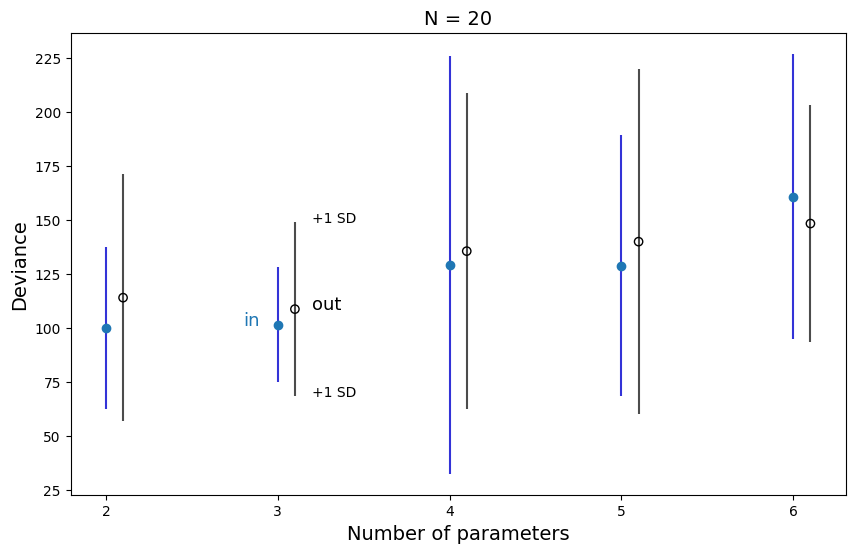

In [10]:
num_param = np.arange(2, param + 1)

plt.figure(figsize=(10, 6))
plt.scatter(num_param, r[:, 0], color="C0")
plt.xticks(num_param)

for j in range(param - 1):
    plt.vlines(
        num_param[j],
        r[j, 0] - r[j, 1],
        r[j, 0] + r[j, 1],
        color="mediumblue",
        zorder=-1,
        alpha=0.80,
    )

plt.scatter(num_param + 0.1, r[:, 2], facecolors="none", edgecolors="k")

for j in range(param - 1):
    plt.vlines(
        num_param[j] + 0.1,
        r[j, 2] - r[j, 3],
        r[j, 2] + r[j, 3],
        color="k",
        zorder=-2,
        alpha=0.70,
    )

dist = 0.20
plt.text(num_param[1] - dist, r[1, 0] - dist, "in", color="C0", fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] - dist, "out", color="k", fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] + r[1, 3] - dist, "+1 SD", color="k", fontsize=10)
plt.text(num_param[1] + dist, r[1, 2] - r[1, 3] - dist, "+1 SD", color="k", fontsize=10)
plt.xlabel("Number of parameters", fontsize=14)
plt.ylabel("Deviance", fontsize=14)
plt.title(f"N = {n}", fontsize=14)
plt.show()

There is a big discrepancy between the plot above and the one in the textbook. I suspect there are problems with the `sim_train_test` function but haven’t had time to debug them.

If you find the problem, you should contribute your fix to the repository. (Or ask your instructor to help if you’re uncertain how to do that.)

## Exercises

Solve all these exercises before class. Today we focus on understanding and interpreting measures of uncertainty and accuracy. In the next lesson, we will apply these metrics.

### Terminology

Carefully distinguish between the following terms — _information entropy_, _divergence_, and _deviance_. Explain what each of these terms means, how we should interpret each quantity, and how each quantity is computed.

In [11]:
# ENTER YOUR ANSWER IN FORUM

### McElreath Exercise 7E3

Suppose a four-sided die is loaded such that, when tossed onto a table, it shows “1” 20%, “2” 25%, “3” 25%, and “4” 30% of the time. What is the entropy of this die?

1. Compute the entropy using the definition.
2. Compute the entropy using the SciPy function `sts.entropy`.

In [12]:
# ENTER YOUR ANSWER IN FORUM

### McElreath Exercise 7E4

Suppose another four-sided die is loaded such that it never shows “4”. The other three sides show equally often. What is the entropy of this die?

In [13]:
# ENTER YOUR ANSWER IN FORUM

### Loaded dice

If you could load a 6-sided die any way you wanted—

1. Which die would have the highest entropy? Explain.
2. Which die would have the lowest entropy? Explain.

In [14]:
# ENTER YOUR ANSWER IN FORUM

### McElreath Exercise 7H3

Consider three fictional Polynesian islands. On each there is a Royal Ornithologist charged by the king with surveying the bird population. They have each found the following proportions of 5 important bird species:

|          | Species A | Species B | Species C | Species D | Species E |
|:-------- |:---------:|:---------:|:---------:|:---------:|:---------:|
| Island 1 | 0.2       | 0.2       | 0.2       | 0.2       | 0.2       |
| Island 2 | 0.8       | 0.1       | 0.05      | 0.025     | 0.025     |
| Island 3 | 0.05      | 0.15      | 0.7       | 0.05      | 0.05      |

Notice that each row sums to 1, all the birds. This problem has two parts. It is not computationally complicated. But it is conceptually tricky. First, compute the entropy of each island’s bird distribution. Interpret these entropy values. Second, use each island’s bird distribution to predict the other two. This means to compute the KL divergence of each island from the others, treating each island as if it were a statistical model of the other islands. You should end up with 6 different KL divergence values. Which island predicts the others best? Why?

**Hint:** You can compute $D_{KL}(p,q) = \sum_i p_i \log\left(\frac{p_i}{q_i}\right)$ directly or you can use the `sts.entropy` function in SciPy.

In [15]:
# ENTER YOUR ANSWER IN FORUM

table = np.array([
    [0.2, 0.2, 0.2, 0.2, 0.2],
    [0.8, 0.1, 0.05, 0.025, 0.025],
    [0.05, 0.15, 0.7, 0.05, 0.05]])

### (Optional but recommended) Desiderata of uncertainty

Prove that the 3 intuitive desiderata for measuring uncertainty (reproduced below) hold for the definition of information entropy.

Desiderata:

1.  The measure of uncertainty should be continuous. If it were not, then an arbitrarily small change in any of the probabilities, for example the probability of rain, would result in a massive change in uncertainty.

2.  The measure of uncertainty should increase as the number of possible events increases. For example, suppose there are two cities that need weather forecasts. In the first city, it rains on half of the days in the year and is sunny on the others. In the second, it rains, shines, and hails, each on 1 out of every 3 days in the year. We’d like our measure of uncertainty to be larger in the second city, where there is one more kind of event to predict.

3.  The measure of uncertainty should be additive. What this means is that if we first measure the uncertainty about rain or shine (2 possible events) and then the uncertainty about hot or cold (2 different possible events), the uncertainty over the four combinations of these events—rain/hot, rain/cold, shine/hot, shine/cold—should be the sum of the separate uncertainties.

Definition of information entropy: $H = -\sum_{i=1}^N p_i \log p_i$

Tasks:

1. Prove that $H$ as defined above is continuous in the binary outcome case — that is where $N=2$ and $p_2 = 1-p_1$, reducing $H$ to a single-variable function. **Hint:** Show that $H$ is differentiable with respect to $p_1$ on the interval $(0,1)$.

2. Compute $H$ for a discrete uniform distribution with $N$ possible outcomes. How does the entropy scale with $N$? According to desideratum 2, we want $H$ to increase as $N$ increases.

3. Show that the entropy computed for the combination of two independent random variables $(X,Y)$ equals the sum of the entropies of the two random variables. That is, show $H((X,Y)) = H(X) + H(Y)$. You can choose any two (preferably different) random variables to demonstrate this. If you want a more challenging exercise, prove this in the general case for any two independent r.v.s.

In [16]:
# ENTER YOUR ANSWER IN FORUM